# Prerequisite

In [2]:
%cd ..

/home/wenli/car_dynamics


In [3]:
import os
import numpy as np

# Single-Env

## Learn f, g

### Pre-train model in simulation

In [5]:
import ray
import wandb
import torch
from env_utils import make_env
from modules.dynamics import DynamicsLearning, VanillaDynamics, EncDynamics
from jax import random
import jax
from datetime import datetime
import string
%load_ext autoreload
%autoreload 2
    
DEBUG=False

In [ ]:
ray.init(ignore_reinit_error=True, local_mode=DEBUG)

print("device", jax.devices())

NUM_DATA = 10_000_000
# NUM_DATA = 1_0_000
DATA_CHUNK = 10000
DATA_DIR = './'
INPUT_DIMS = 11
OUTPUT_DIMS = 5
ACTION_DIMS = 2
REPR_DIMS = 2 
BATCH_SIZE = 10_000
ENV_DIMS=4

now = datetime.now()
FILE_NAME = f'{now.strftime("%Y")}-{now.strftime("%m")}-{now.strftime("%d")}-{now.strftime("%H:%M:%S")}'
DYN_MODEL_DIR = f'models/dyn_model/{FILE_NAME}/'


# DYN_DATA_DIR = f'dataset/{FILE_NAME}'
DYN_DATA_DIR = 'dataset/2023-10-21-18:25:06'

def env_gen():
    # return make_env('point-wind-v0')
    # return make_env('point-reach-goal-multi-v3', wind_list=WIND_LIST)
    return make_env('car-base-single')


run = wandb.init(
    project="car-dynamics",
    config= {
        'mode': 'dynamics',
        'num_data': NUM_DATA,
        'dyn_model_dir': DYN_MODEL_DIR,
        'dyn_data_dir': DYN_DATA_DIR,
        'single_env': True,
    },
    mode = "disabled" if DEBUG else "online",
)

key1 = random.PRNGKey(123)
# dyn_model = EncDynamics(INPUT_DIMS, OUTPUT_DIMS, ACTION_DIMS, key1,
#         env_dims=ENV_DIMS, model_dir=DYN_MODEL_DIR,DEBUG=DEBUG,batch_size=BATCH_SIZE, repr_dims=REPR_DIMS)

fix_model = VanillaDynamics(INPUT_DIMS, OUTPUT_DIMS, ACTION_DIMS, 
                            key1, model_dir=DYN_MODEL_DIR,DEBUG=DEBUG,
                            batch_size=BATCH_SIZE, env_dims=ENV_DIMS)

fix_learner = DynamicsLearning(fix_model, env_gen, run, DEBUG=DEBUG)
fix_learner.learn(num_data = NUM_DATA, train_epoches=1000, evaluate_episodes=20, data_chunk=DATA_CHUNK, 
                  # save_data_dir=DYN_DATA_DIR)
                  load_data={'file_name':DYN_DATA_DIR})


### Fine-tune with real-data

#### prepare real dataset

In [65]:
### Create Dataset **FROM REAL-WORLD DATA** ###
TUNE_DATA_DIR = './dataset/tune-dataset/'
files = os.listdir(TUNE_DATA_DIR)
files.sort()

data_list = []
label_list = []
for f in files:
    if 'csv' not in f:
        continue
    real_traj = np.loadtxt(f'{TUNE_DATA_DIR}/{f}',delimiter=',')
    #REF: self.frames.append(np.concatenate((state,[goal_x, goal_y], [throttle,str_val, time.time()]),axis=0))
    state_list = []
    action_list = []
    for i, data_i in enumerate(real_traj):
        assert data_i.shape[0] == 9
        x = data_i[0]
        y = data_i[1]
        yaw = data_i[2]
        yaw_x = np.cos(yaw)
        yaw_y = np.sin(yaw)
        vel = data_i[3]
        a0 = data_i[6]
        a1 = data_i[7]
        state_list.append(np.array([x,y,yaw_x,yaw_y,vel]))
        action_list.append([a0,a1])

        if i > 0:
            data_list.append(np.concatenate((state_list[i-1], [7., .02, .34, 5.], action_list[i-1])))
            label_list.append(state_list[i] - state_list[i-1])

data_list = np.array(data_list)
label_list = np.array(label_list)

data_size = data_list.shape[0]

## Shuffle, ortherwise there's overfitting problem
idxs = list(range(data_size))
np.random.shuffle(idxs)

tune_train_data, tune_test_data = data_list[idxs[:int(data_size*.7)]], data_list[idxs[int(data_size*.7):]]
tune_train_label, tune_test_label = label_list[idxs[:int(data_size*.7)]], label_list[idxs[int(data_size*.7):]]

#### Tune model

- Also evalutate the performance of the tuned model
- Search lr, batch_size, and epoches

In [ ]:
DEBUG = False
from modules.data_utils import convert_to_dataset
from modules.dynamics import VanillaDynamics
from datetime import datetime
import wandb
from jax import random



LEARNING_RATE = 1e-4
EPOCHES = 1000
BATCH_SIZE = 512
for LEARNING_RATE in [1e-4]:
    for EPOCHES in [500]:
        for BATCH_SIZE in [256]:

            now = datetime.now()
            FILE_NAME = f'{now.strftime("%Y")}-{now.strftime("%m")}-{now.strftime("%d")}-{now.strftime("%H:%M:%S")}'
            TUNE_MODEL_DIR = f'models/tune_model/{FILE_NAME}/'
            run = wandb.init(
                project="car-dynamics",
                config= {
                    'mode': 'tune',
                    'tune_model_dir': TUNE_MODEL_DIR,
                    'single_env': True,
                    'lr': LEARNING_RATE,
                    'batch_size': BATCH_SIZE,
                    'epoches': EPOCHES,
                },
                mode = "disabled" if DEBUG else "online",
            )
            
            ## Load learned dynamics model
            INPUT_DIMS = 11
            OUTPUT_DIMS = 5
            ACTION_DIMS = 2
            ENV_DIMS=4
            FIX_MODEL_DIR = 'models/dyn_model/2023-10-21-19:25:56/'
            key1 = random.PRNGKey(123)
            fix_model = VanillaDynamics(INPUT_DIMS, OUTPUT_DIMS, ACTION_DIMS, key1,
                        env_dims=ENV_DIMS, model_dir=FIX_MODEL_DIR,DEBUG=DEBUG,)
            fix_model.load()
            
            ## Normalize data
            data_min = fix_model._data_min
            data_max = fix_model._data_max
            label_min = fix_model._labels_min
            label_max = fix_model._labels_max
            tune_train_data = (tune_train_data - data_min) / (data_max - data_min + 1e-8)
            tune_train_label = (tune_train_label - label_min) / (label_max - label_min + 1e-8)
            
            dataset = convert_to_dataset(tune_train_data, tune_train_label)
            
            print(f"[INFO] DATA PREPARED. SIZE: {dataset.length}")
            
            ## Tunning pipeline
            fix_model.tune(run, dataset, epoches=EPOCHES, learning_rate=LEARNING_RATE, 
                           batch_size=BATCH_SIZE, tune_model_dir=TUNE_MODEL_DIR)
            
            ## Evaluate the tuned model
            y_tune = fix_model.predict(tune_test_data)
            error_tune = np.abs(y_tune - tune_test_label)
            log_dict = {}
            for i in range(5):
                log_dict[f'eval_error_mean_{i}'] = np.mean(error_tune[:,i]) 
                log_dict[f'eval_error_std_{i}'] = np.std(error_tune[:,i]) 
            run.log(log_dict)

### Evaluate Models (w/,w/o tune on new data)

#### Load models

> tuned model learning curve: https://wandb.ai/randyxiao/car-dynamics/runs/ynj4bv9i/overview?workspace=user-randyxiao

> w/o tune model learning curve: https://wandb.ai/randyxiao/car-dynamics/runs/b58wteld/overview?workspace=user-randyxiao

In [67]:
DEBUG = False
INPUT_DIMS = 11
OUTPUT_DIMS = 5
ACTION_DIMS = 2
ENV_DIMS=4


from modules.dynamics import VanillaDynamics
from datetime import datetime
import wandb


woTUNE_MODEL_DIR = 'models/dyn_model/2023-10-21-19:25:56'
TUNE_MODEL_DIR = 'models/tune_model/2023-10-22-17:18:26'
key = random.PRNGKey(123)
key_wo_tune, key_tune = random.split(key, 2)
# load model wo tune
wo_tune_model = VanillaDynamics(INPUT_DIMS, OUTPUT_DIMS, ACTION_DIMS, key_wo_tune,
            env_dims=ENV_DIMS, model_dir=woTUNE_MODEL_DIR,DEBUG=DEBUG,)
wo_tune_model.load()
# load model tune
tune_model = VanillaDynamics(INPUT_DIMS, OUTPUT_DIMS, ACTION_DIMS, key_tune,
            env_dims=ENV_DIMS, model_dir=TUNE_MODEL_DIR,DEBUG=DEBUG,)
tune_model.load()

[Info] Loading from models/dyn_model/2023-10-21-19:25:56 ...
[Info] Loading from models/tune_model/2023-10-22-17:18:26 ...


### Evaluate on Sim-Synthesized data

In [86]:
from env_utils import make_env
sim_data = []
sim_label = []
prev_state = None

env = make_env('car-base-single')
for i in range(100):
    prev_state = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        state, _, done, _ = env.step(action)
        sim_data.append(np.concatenate((prev_state,action),axis=0))
        sim_label.append(state[:5]-prev_state[:5])
        prev_state = state + .0
sim_data = np.array(sim_data)
sim_label = np.array(sim_label)


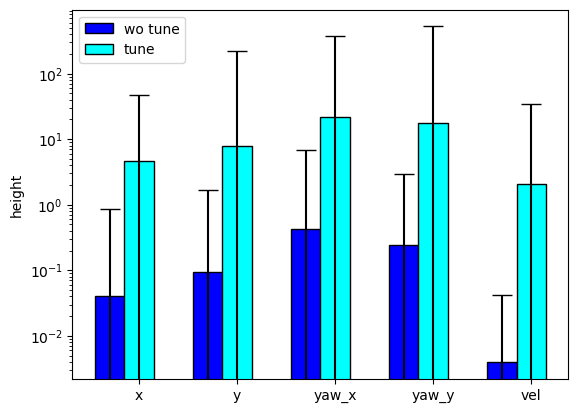

In [111]:
from rich.progress import track

test_data = sim_data
test_label = sim_label

error_tune = []
error_wo_tune = []

y_tune = tune_model.predict(test_data)
error_tune = (y_tune - test_label) / (test_label + 1e-3)

y_wo_tune = wo_tune_model.predict(test_data)
error_wo_tune = (y_wo_tune - test_label) /(test_label + 1e-3)

%matplotlib inline
import matplotlib.pyplot as plt
# width of the bars
barWidth = 0.3

bars1 = [np.mean(np.abs(error_wo_tune[:,i])) for i in range(5)]
 
# Choose the height of the cyan bars
bars2 = [np.mean(np.abs(error_tune[:,i])) for i in range(5)]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(np.abs(error_wo_tune[:,i])) for i in range(5)]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(np.abs(error_tune[:,i])) for i in range(5)]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='wo tune')

# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='tune')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['x','y','yaw_x','yaw_y','vel'])
plt.ylabel('error')
plt.legend()
plt.yscale('log')
 
# Show graphic
plt.show()

#### Evaluate on Tuning-Test dataset

We first calculate the raw error between y and $\hat y$

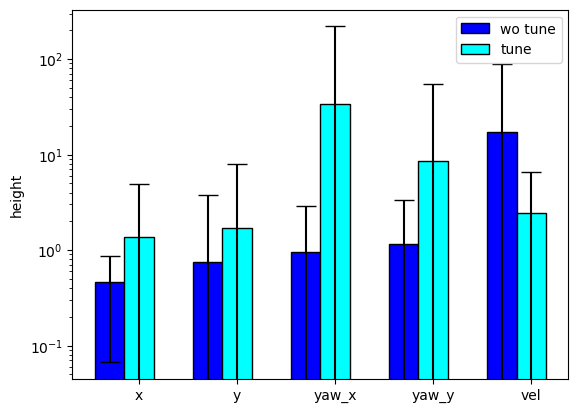

In [112]:
from rich.progress import track
error_tune = []
error_wo_tune = []

y_tune = tune_model.predict(tune_test_data)
error_tune = (y_tune - tune_test_label) / (tune_test_label + 1e-3)

y_wo_tune = wo_tune_model.predict(tune_test_data)
error_wo_tune = (y_wo_tune - tune_test_label) / (tune_test_label + 1e-3)

%matplotlib inline
import matplotlib.pyplot as plt
# width of the bars
barWidth = 0.3

bars1 = [np.mean(np.abs(error_wo_tune[:,i])) for i in range(5)]
 
# Choose the height of the cyan bars
bars2 = [np.mean(np.abs(error_tune[:,i])) for i in range(5)]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(np.abs(error_wo_tune[:,i])) for i in range(5)]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(np.abs(error_tune[:,i])) for i in range(5)]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='wo tune')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='tune')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['x','y','yaw_x','yaw_y','vel'])
plt.ylabel('error')
plt.legend()
plt.yscale('log')
 
# Show graphic
plt.show()

#### Evaluate on Evaluate (Car/Box/Chair) Data

In [70]:
def rotate_180(angles):
    new_angles = np.zeros_like(angles)
    for i, angle in enumerate(angles):   
        xs = np.cos(angle)
        ys = np.sin(angle)
        new_angles[i] = np.arctan2(-ys,-xs)
    return new_angles

def calc_vel(data):
    vel_calc = [0.]
    for i in range(1,len(data)):
        dist = np.linalg.norm(data[i][:2] - data[i-1][:2])
        vel_calc.append(dist/(data[i,-1]-data[i-1,-1]))
    return np.array(vel_calc)

In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
data_dir = './dataset/car-data-x/'

files = {
    'throw': [
        {'path':'2023-10-10-22_11_11-wqf.txt','st':1,'ed':-1},
    ],
    'drag': [
        {'path':'2023-10-10-22_19_29-ek4.txt','st':1,'ed':-1},
    ],
    'box': [
        {'path':'2023-10-10-22_15_14-hwd.txt','st':1,'ed':-1},
    ],
    'car': [
        {'path':'2023-10-10-21_35_06-pvg.txt','st':1,'ed':-1},
        {'path':'2023-10-10-21_38_31-572.txt','st':1,'ed':-1},
        
    ],
}

In [72]:
eval_data_dict = {}
for EXP_TYPE in ['car','box','drag','throw']:    
    f = files[EXP_TYPE][0]['path']
    st = files[EXP_TYPE][0]['st']
    ed = files[EXP_TYPE][0]['ed']
    data = np.loadtxt(os.path.join(data_dir,f))
    data = data[st:ed]
    data[:,2] = rotate_180(data[:,2])
    data[:,3] = calc_vel(data)
    data[:,-1] -= data[0,-1]
    X = []
    y = []
    for i in range(1, len(data)):
        # print(data.shape)
        pos_x, pos_y, yaw, vel, throttle, str_val, _= data[i-1]
        yaw_x, yaw_y = np.cos(yaw), np.sin(yaw)
        xt_1 = np.array([pos_x,pos_y,yaw_x,yaw_y,vel])
        x_t = np.array([data[i][0],data[i][1],np.cos(data[i][2]),np.sin(data[i][2]),data[i][3]])
        
        X.append([pos_x,pos_y,yaw_x,yaw_y,vel,7., .02, .34, 5.,throttle,str_val])
        y.append(x_t - xt_1)
    eval_data_dict[EXP_TYPE] = dict()
    eval_data_dict[EXP_TYPE]['data'] = np.array(X)
    eval_data_dict[EXP_TYPE]['label'] = np.array(y)

car 2.4203376801593715


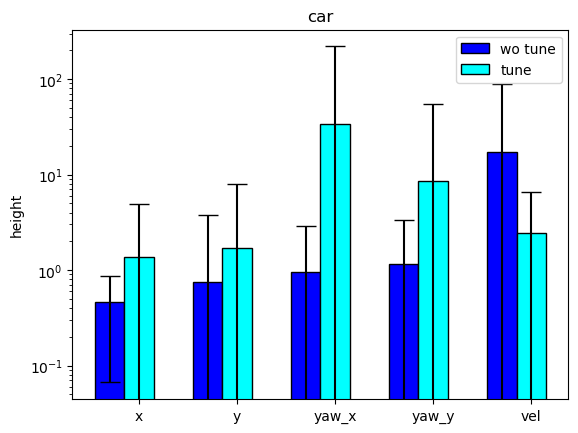

box 3.1347819785560023


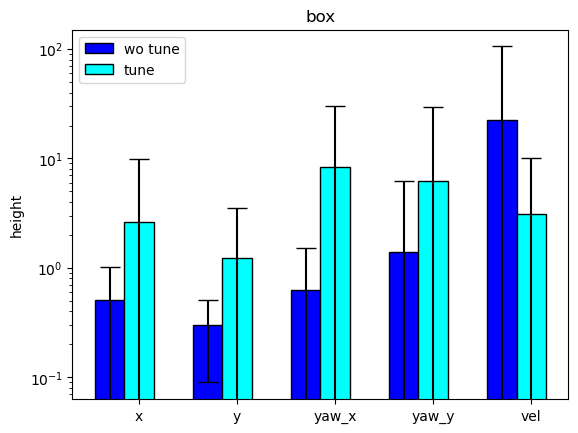

drag 12.642606735594212


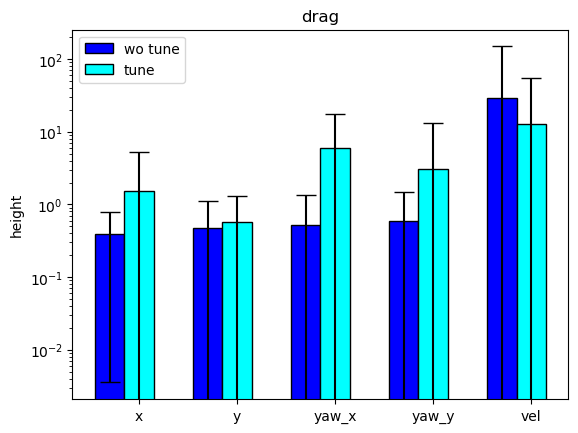

throw 4.451103324841319


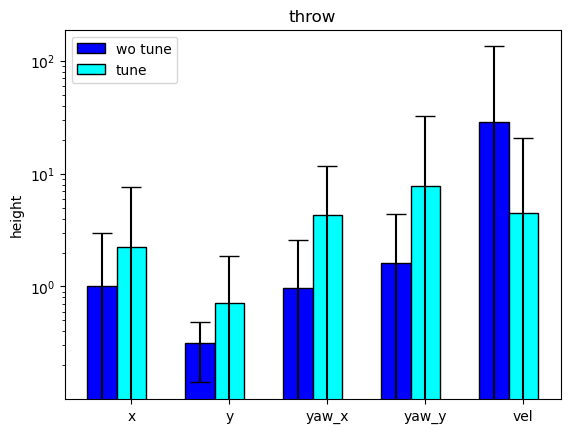

In [117]:
from rich.progress import track
for EXP_TYPE in ['car','box','drag','throw']:
    test_data = eval_data_dict[EXP_TYPE]['data']
    test_label = eval_data_dict[EXP_TYPE]['label']
    
    error_tune = []
    error_wo_tune = []
    
    y_tune = tune_model.predict(test_data)
    error_tune = (y_tune - test_label) / (test_label + 1e-3)
    
    y_wo_tune = wo_tune_model.predict(test_data)
    error_wo_tune = (y_wo_tune - test_label) / (test_label + 1e-3)
    
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    plt.figure()
    # width of the bars
    barWidth = 0.3
    
    bars1 = [np.mean(np.abs(error_wo_tune[:,i])) for i in range(5)]
     
    # Choose the height of the cyan bars
    bars2 = [np.mean(np.abs(error_tune[:,i])) for i in range(5)]
     
    # Choose the height of the error bars (bars1)
    yer1 = [np.std(np.abs(error_wo_tune[:,i])) for i in range(5)]
     
    # Choose the height of the error bars (bars2)
    yer2 = [np.std(np.abs(error_tune[:,i])) for i in range(5)]
     
    # The x position of bars
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
     
    # Create blue bars
    plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='wo tune')
     
    # Create cyan bars
    plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='tune')
     
    # general layout
    plt.xticks([r + barWidth for r in range(len(bars1))], ['x','y','yaw_x','yaw_y','vel'])
    plt.ylabel('error')
    plt.legend()
    plt.yscale('log')
    print(EXP_TYPE, np.mean(np.abs(error_tune[:,4])))
    plt.title(EXP_TYPE)
    # Show graphic
    plt.show()

### Evaluate on Mix data

# Multi-Env

## Learn f, g

### Pre-train Model in Simulation 

In [7]:
import ray
import wandb
import torch
from env_utils import make_env
from modules.dynamics import DynamicsLearning, EncDynamics
from modules.adaptation import AdaptationDynamics, AdaptationLearning
from jax import random
import jax
from datetime import datetime
import string

%load_ext autoreload
%autoreload 2
    
DEBUG=False

def env_gen():
    return make_env('car-base')

WINDOW_LENGTH = 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Dyn Model

In [ ]:
ray.init(ignore_reinit_error=True, local_mode=DEBUG)

print("device", jax.devices())

NUM_DATA = 1_000_000
# NUM_DATA = 1_0_000
DATA_CHUNK = 10000
DATA_DIR = './'
INPUT_DIMS = 11
OUTPUT_DIMS = 5
ACTION_DIMS = 2
REPR_DIMS = 2 
BATCH_SIZE = 10_000
ENV_DIMS=4

now = datetime.now()
FILE_NAME = f'{now.strftime("%Y")}-{now.strftime("%m")}-{now.strftime("%d")}-{now.strftime("%H:%M:%S")}'
DYN_MODEL_DIR = f'models/dyn_model/{FILE_NAME}/'

DYN_DATA_DIR = f'dataset/{FILE_NAME}'
# DYN_DATA_DIR = 'dataset/2023-10-21-18:25:06'

run = wandb.init(
    project="car-dynamics",
    config= {
        'mode': 'dynamics',
        'num_data': NUM_DATA,
        'dyn_model_dir': DYN_MODEL_DIR,
        'dyn_data_dir': DYN_DATA_DIR,
        'single_env': False,
    },
    mode = "disabled" if DEBUG else "online",
)

key1 = random.PRNGKey(123)
dyn_model = EncDynamics(INPUT_DIMS, OUTPUT_DIMS, ACTION_DIMS, key1,
        env_dims=ENV_DIMS, model_dir=DYN_MODEL_DIR,DEBUG=DEBUG,batch_size=BATCH_SIZE, repr_dims=REPR_DIMS)

# fix_model = VanillaDynamics(INPUT_DIMS, OUTPUT_DIMS, ACTION_DIMS, 
#                             key1, model_dir=DYN_MODEL_DIR,DEBUG=DEBUG,
#                             batch_size=BATCH_SIZE, env_dims=ENV_DIMS)

dyn_learner = DynamicsLearning(dyn_model, env_gen, run, DEBUG=DEBUG)
dyn_learner.learn(num_data = NUM_DATA, train_epoches=1000, evaluate_episodes=20, data_chunk=DATA_CHUNK, 
                  save_data_dir=DYN_DATA_DIR)
                  # load_data={'file_name':DYN_DATA_DIR})


#### Adapt Model

In [6]:
DEBUG = False

ray.init(ignore_reinit_error=True, local_mode=DEBUG)


now = datetime.now()
FILE_NAME = f'{now.strftime("%Y")}-{now.strftime("%m")}-{now.strftime("%d")}-{now.strftime("%H:%M:%S")}'
ADAPT_MODEL_DIR = f'models/adapt_model/{FILE_NAME}/'
ADAPT_DATA_DIR = f'dataset/adapt-{FILE_NAME}'

print("device", jax.devices())

NUM_DATA = 1_000_000
DATA_CHUNK = 10_000
DATA_DIR = './'
DYN_INPUT_DIMS = 11
TRAIN_EPOCHES = 500
OUTPUT_DIMS = 5
ACTION_DIMS = 2
REPR_DIMS = 2 
BATCH_SIZE = 10_000
DYN_ENV_DIMS= 4
LEARNING_RATE = 1e-3
ADAPT_ENV_DIMS = (DYN_INPUT_DIMS - DYN_ENV_DIMS)*WINDOW_LENGTH - ACTION_DIMS
ADAPT_INPUT_DIMS =  ADAPT_ENV_DIMS + DYN_INPUT_DIMS - DYN_ENV_DIMS
# DYN_MODEL_DIR = 'models/test/dyn_model/'
DYN_MODEL_DIR = 'models/dyn_model/2023-10-22-21:59:51'

run = wandb.init(
    project="car-dynamics",
    config= {
        'mode': 'adaptation',
        'num_data': NUM_DATA,
        'dyn_model_dir': DYN_MODEL_DIR,
        'adapt_data_dir': ADAPT_DATA_DIR,
        'adapt_model_dir': ADAPT_MODEL_DIR,
        'window_length': WINDOW_LENGTH,
        'lr': LEARNING_RATE,
        'single_env': False,
    },
    mode = "disabled" if DEBUG else "online",
)

key1 = random.PRNGKey(123)
key_dyn, key_adapt = random.split(key1, 2)
dyn_model = EncDynamics(DYN_INPUT_DIMS, OUTPUT_DIMS, ACTION_DIMS, key_dyn,
        env_dims=DYN_ENV_DIMS, model_dir=DYN_MODEL_DIR,DEBUG=DEBUG,repr_dims=REPR_DIMS)
dyn_model.load()

target_enc = dyn_model.export_enc()
head_info = dyn_model.export_head()

adapt_model = AdaptationDynamics(ADAPT_INPUT_DIMS, OUTPUT_DIMS, ACTION_DIMS, key_adapt,
        env_dims=ADAPT_ENV_DIMS, model_dir=ADAPT_MODEL_DIR,DEBUG=DEBUG,env_params_dims=DYN_ENV_DIMS,
        learning_rate=LEARNING_RATE, repr_dims=REPR_DIMS,batch_size=BATCH_SIZE, dyn_head_info=head_info)   

adapt_learner = AdaptationLearning(adapt_model, env_gen, run, 
        DEBUG=DEBUG,window_length=WINDOW_LENGTH, target_enc=target_enc)


adapt_learner.learn(num_data = NUM_DATA, evaluate_episodes=20, train_epoches=1000, 
                       save_data_dir=ADAPT_DATA_DIR)

2023-10-23 11:17:44,421	INFO worker.py:1476 -- Calling ray.init() again after it has already been called.


device [gpu(id=0)]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


evaluating/validation_mse_error0,█▃▃▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
evaluating/validation_mse_error1,█▆▇▇▆▆▆▆▆▆▆▆▆▅▆▅▅▅▅▅▄▄▄▅▄▃▃▃▅▃▄▃▃▂▃▂▂▃▂▁
testing/delta0,▄▃▃▁▄▃▅▆▄▇▄▂▄▆▅▆▇▃▁▃▄▇▅▆▆█▅▃▃▂▃▄▄▆▇▄▄▅▅▃
testing/delta1,▄▅▅▅▄▄▄▂▄▃▄▄▄▄▄▄▄▄▁▂▄▅▄▄▆█▄▄▃▁▂▃▃▆▅▃▃▄▄▂
testing/delta2,▅▄▅▆▅▅▅▄▅▆▄▅▅▆▅▅▅▄▇▆▄▅▅▇▅▁▅▄▆▆▆▅▆▅█▅▅▅▅▄
testing/delta3,▅▄▄▅▄▅▅▃▅▅▄▄▅▃▅▄▄▅▁▃▅▅▅▃▄█▅▆▃▄▃▄▃▅▂▄▅▅▄▅
testing/delta4,▇▆▆▁▃▁▁▇▁▇▇▅▄▇▆▄▆▆▂▃▂▆▂▅▂█▅▅▅▆▄▅▂▂▄▃▅▆▅▅
testing/deltaReal0,▄▃▃▁▄▃▅▆▄▇▄▂▄▆▅▆▇▃▁▃▄▇▅▆▆█▅▃▃▂▃▄▄▆▇▄▄▅▅▃
testing/deltaReal1,▄▅▅▅▄▄▄▂▄▃▄▄▄▃▄▄▄▄▁▂▄▅▄▄▆█▄▄▃▁▂▃▃▆▅▃▃▄▄▂
testing/deltaReal2,▄▃▄▅▄▄▄▃▄▅▄▄▄▅▄▄▅▄█▆▄▄▄▆▄▁▄▄▅▅▆▅▆▄█▅▄▄▅▃
testing/deltaReal3,▅▄▄▅▄▄▄▃▄▅▄▄▅▃▅▄▄▅▁▃▅▄▄▃▄█▅▆▃▄▃▄▃▅▂▄▅▄▄▅


[Info] Loading from models/dyn_model/2023-10-22-21:59:51 ...


Output()

[INFO] Create path:dataset/adapt-2023-10-23-11:17:44
[INFO] On_train_start, data size: 960000


Output()

Output()

(96,) 3.747396984198911

(96,) 0.35111600557548

/home/wenli/miniforge3/envs/safeDPA/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


(96,) 0.09502367616390446

(96,) 0.23054788546549823

(96,) 0.03396635039941459

(96,) 0.058741429631004725

(96,) 0.07461829782074521

(96,) 0.12620596001244108

(96,) 0.20346455088234194

(96,) 0.05187453295094119

(96,) 0.08057552435330993

(96,) 0.05115510947309424

(96,) 7.274941096161769

(96,) 0.0481719694203157

(96,) 0.07086091082100565

(96,) 0.3035098695873718

(96,) 1.0866611145489742

(96,) 0.04877806693862118

(96,) 0.0904551661952987

(96,) 0.06533265379356214

### Fine-tune with real-data

#### prepare real dataset

In [28]:
### Create Dataset **FROM REAL-WORLD DATA** ###
TUNE_DATA_DIR = './dataset/tune-dataset/'
files = os.listdir(TUNE_DATA_DIR)
files.sort()

data_list = []
label_list = []
for f in files:
    if 'csv' not in f:
        continue
    real_traj = np.loadtxt(f'{TUNE_DATA_DIR}/{f}',delimiter=',')
    #REF: self.frames.append(np.concatenate((state,[goal_x, goal_y], [throttle,str_val, time.time()]),axis=0))
    state_list = []
    action_list = []
    for i, data_i in enumerate(real_traj):
        assert data_i.shape[0] == 9
        x = data_i[0]
        y = data_i[1]
        yaw = data_i[2]
        yaw_x = np.cos(yaw)
        yaw_y = np.sin(yaw)
        vel = data_i[3]
        a0 = data_i[6]
        a1 = data_i[7]
        state_list.append(np.array([x,y,yaw_x,yaw_y,vel]))
        action_list.append([a0,a1])

        if i >= WINDOW_LENGTH:
            X = np.concatenate((state_list[i-WINDOW_LENGTH:i], 
                                action_list[i-WINDOW_LENGTH:i]), axis=1)
            X = np.concatenate(X, axis=0)
            X = X[:-2]
            X = np.concatenate((state_list[i-1], X, action_list[i-1]), axis=0)
            data_list.append(X)
            label_list.append(state_list[i] - state_list[i-1])

data_list = np.array(data_list)
label_list = np.array(label_list)

data_size = data_list.shape[0]

## Shuffle, ortherwise there's overfitting problem
idxs = list(range(data_size))
np.random.shuffle(idxs)

tune_train_data, tune_test_data = data_list[idxs[:int(data_size*.7)]], data_list[idxs[int(data_size*.7):]]
tune_train_label, tune_test_label = label_list[idxs[:int(data_size*.7)]], label_list[idxs[int(data_size*.7):]]

In [29]:
tune_train_data.shape

(9571, 40)

#### Tune adapt model

- Also evalutate the performance of the tuned model
- Search lr, batch_size, and epoches

First, load the trained adapt model

In [30]:
DYN_MODEL_DIR = 'models/dyn_model/2023-10-22-21:59:51'
ADAPT_MODEL_DIR = 'models/adapt_model/2023-10-23-11:17:44'

key1 = random.PRNGKey(123)
key_dyn, key_adapt = random.split(key1, 2)
dyn_model = EncDynamics(DYN_INPUT_DIMS, OUTPUT_DIMS, ACTION_DIMS, key_dyn,
        env_dims=DYN_ENV_DIMS, model_dir=DYN_MODEL_DIR,DEBUG=DEBUG,repr_dims=REPR_DIMS)
dyn_model.load()
# target_enc = dyn_model.export_enc()
head_info = dyn_model.export_head()

adapt_model = AdaptationDynamics(ADAPT_INPUT_DIMS, OUTPUT_DIMS, ACTION_DIMS, key_adapt,
        env_dims=ADAPT_ENV_DIMS, model_dir=ADAPT_MODEL_DIR,DEBUG=DEBUG,env_params_dims=DYN_ENV_DIMS,
        repr_dims=REPR_DIMS, dyn_head_info=head_info)
adapt_model.load()
adapt_model.deploy_dynamics()

[Info] Loading from models/dyn_model/2023-10-22-21:59:51 ...
[Info] Loading from models/adapt_model/2023-10-23-11:17:44 ...


In [45]:
DEBUG = False
from modules.data_utils import convert_to_dataset
# from modules.dynamics import VanillaDynamics
from datetime import datetime
import wandb
from jax import random

LEARNING_RATE = 1e-4
EPOCHES = 1000
BATCH_SIZE = 512
for LEARNING_RATE in [1e-4]:
    for EPOCHES in [500]:
        for BATCH_SIZE in [256]:

            now = datetime.now()
            FILE_NAME = f'{now.strftime("%Y")}-{now.strftime("%m")}-{now.strftime("%d")}-{now.strftime("%H:%M:%S")}'
            TUNE_MODEL_DIR = f'models/tune_model/{FILE_NAME}/'
            TUNE_HEAD_DIR = f'models/tune_head/{FILE_NAME}/'
            run = wandb.init(
                project="car-dynamics",
                config= {
                    'mode': 'adapt-tune',
                    'tune_model_dir': TUNE_MODEL_DIR,
                    'single_env': True,
                    'lr': LEARNING_RATE,
                    'batch_size': BATCH_SIZE,
                    'epoches': EPOCHES,
                },
                mode = "disabled" if DEBUG else "online",
            )
            
            ## Normalize data
            data_min = adapt_model._dyn_data_min
            data_max = adapt_model._dyn_data_max
            label_min = adapt_model._dyn_labels_min
            label_max = adapt_model._dyn_labels_max
            tune_train_data = (tune_train_data - data_min) / (data_max - data_min + 1e-8)
            tune_train_label = (tune_train_label - label_min) / (label_max - label_min + 1e-8)
            
            dataset = convert_to_dataset(tune_train_data, tune_train_label)
            
            print(f"[INFO] DATA PREPARED. SIZE: {dataset.length}")
            
            ## Tunning pipeline
            adapt_model.tune('all', run, dataset, epoches=EPOCHES, learning_rate=LEARNING_RATE, 
                           batch_size=BATCH_SIZE, tune_model_dir=TUNE_MODEL_DIR, tune_head_dir=TUNE_HEAD_DIR,
                            data_split_rate=0.8)
            
            ## Evaluate the tuned model
            y_tune = adapt_model.predict_dynamics(tune_test_data)
            error_tune = np.abs(y_tune - tune_test_label)
            log_dict = {}
            for i in range(5):
                log_dict[f'eval_error_mean_{i}'] = np.mean(error_tune[:,i]) 
                log_dict[f'eval_error_std_{i}'] = np.std(error_tune[:,i]) 
            run.log(log_dict)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Output()

(1024, 40)

(1024, 33)

[INFO] DATA PREPARED. SIZE: 9571


ScopeParamNotFoundError: Could not find parameter named "kernel" in scope "/enc/layers_0". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamNotFoundError)

In [43]:
adapt_model.input_dims

40